In [1]:
# First import useful package
import numpy as np
import matplotlib.pyplot as plt

##### True Processes 
We have an unobserved state variable $x$ and an observable variable $y$. The two variables evlove as

$$x_{t+1} = A x_t + Cw_{t+1}$$
$$y_t = G x_t + v_t$$

where
\begin{align*}
A = \begin{bmatrix}
1 & 0 \\
0.1 & 1
\end{bmatrix}
,\ C = \begin{bmatrix}
1  \\
0
\end{bmatrix},\ G = \begin{bmatrix}
1 & 1
\end{bmatrix}
\end{align*}
First let's simulate the process

In [2]:
A = np.array([[ 1, 0],
             [.1, 1]])
C = np.array([[1],[0]])
G = np.array([1,1])

x = np.zeros([101,2])
y = np.zeros(100)
w = np.zeros(100)
v = np.zeros(100)
x[0] = np.random.multivariate_normal([0,0], [[20,5],[5,20]])

for t in range(100):
    w[t] = np.random.normal(0,1)
    v[t] = np.random.normal(0,np.sqrt(5))
    y[t] = G @ np.vstack(x[t]) + v[t]
    x[t+1] = np.hstack(A @ np.vstack(x[t]) + (C * w[t]))

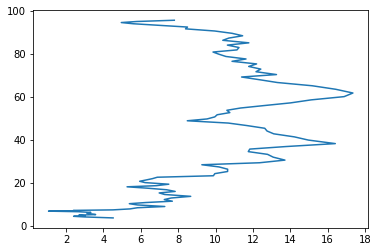

In [3]:
plt.plot(x[:,0], x[:,1])

##### Algebra Part
In real world, we only observe $y$, how can we predict the underlining state $x$? Kalman filter constructs the optimal forecast of the path of the underlying state $\hat x$, given the observed measurements.

We assume an initial condition $x_0\sim N(\hat x_0,\Sigma_0)$. By linearity of the system, before the realization of $y_0$, the prior belief of $y_0$ would just be 
$$y_0 = G x_0 + v_0\Rightarrow y_0\sim N(G\hat x_0, G\Sigma_0G'+ \sigma^2_v)$$

Let's split $x_0 = \hat x_0 + (x_0-\hat x_0),\ y_0 = G \hat x_0 + (y_0 - G \hat x_0)$ and project the unknown $x_0-\hat x_0$ on the new information $y_0 - G \hat x_0$

\begin{align*}x_0-\hat x_0 &= \beta_0(y_0 - G \hat x_0) + \varepsilon_0\\
(x_0-\hat x_0)(y_0-G\hat x_0)'&= \beta_0(y_0 - G \hat x_0)(y_0-G\hat x_0)' + \varepsilon_0(y_0-G\hat x_0)'\\
\underbrace{\mathbb{E}[(x_0-\hat x_0)(y_0-G\hat x_0)']}_{=Cov(x_0,y_0|\hat x_0,\Sigma_0)}&= \underbrace{\mathbb{E}[\beta_0(y_0 - G \hat x_0)(y_0-G\hat x_0)']}_{=\beta_0Var(y_0|\hat x_0,\Sigma_0)} + \underbrace{\mathbb{E}[\varepsilon_0(y_0-G\hat x_0)']}_{=0 \ (\text{by the linear projection})} \\
\Sigma_0 G' &= \beta_0(G\Sigma_0G'+ \sigma^2_v)\\
\beta_0 &= \Sigma_0 G'(G\Sigma_0G'+ \sigma^2_v)^{-1}
\end{align*}

Despite we know it's the truth, we assume $x_{t+1} = A x_t + Cw_{t+1}$
$$x_1 = A x_0 + C w_1 = A\hat x_0 + A (x_0-\hat x_0)+ Cw_{1}$$
Define $y^{t-1} = \{y_0,...,y_{t-1}\}$
\begin{align*}\hat x_1 &= \mathbb{E}[x_1|y^0] = \mathbb{E}[A\hat x_0 + A (x_0-\hat x_0)+ Cw_{1}|y^0]\\
&= A\hat x_0 + \mathbb{E}[A (x_0-\hat x_0)|y^0] \underbrace{\Rightarrow}_{\text{from above projection}} A\hat x_0 + A\beta_0(y_0-G\hat x_0)
\end{align*}
Where $K_0 := A\beta_0 = A\Sigma_0 G'(G\Sigma_0G'+ \sigma^2_v)^{-1}$ is called $\textbf{Kalman gain}$.

We can also track the covariance matrix
\begin{align*}
x_1-\hat x_1 &= Ax_0+Cw_1- A\hat x_0 - K_0(y_0-G\hat x_0)\\
& = A(x_0-\hat x_0) + Cw_1 - K_0(Gx_0+v_0-G\hat x_0)\\
& = (A-K_0G)(x_0-\hat x_0) + Cw_1 -K_0v_0\\
\Sigma_1 = \mathbb{E}[(x_1-\hat x_1)(x_1-\hat x_1)'] &= (A-K_0G)\Sigma_0(A-K_0G)' + C\sigma^2_wC' + K_0\sigma^2_v K_0'
\end{align*}

Finally we have the dynamic system:
\begin{align*}
K_t &= A\Sigma_t G'(G\Sigma_tG'+ \sigma^2_v)^{-1}\\
\hat x_{t+1} &= A\hat x_{t} + K_t(y_t-G\hat x_t) \\
\Sigma_{t+1} &= (A-K_tG)\Sigma_t(A-K_tG)' + C\sigma^2_wC' + K_t\sigma^2_v K_t'
\end{align*}
where $\hat x_{t}$ is called filter path

##### Coding Part

In [4]:
def Kalman_filter(y, x_0, Σ_0, A, G, C, σ_w, σ_v):
    x = [None] * len(y+1)
    Σ = [None] * len(y+1)
    K = [None] * len(y)
    x[0] = x_0
    Σ[0] = Σ_0    
    for t in range(0,len(y)-1):
        K[t] = A @ Σ[t] @ G.T * (G @ Σ[0] @ G.T + σ_v**2)**(-1)
        x[t+1] = np.hstack(A @ np.vstack(x[t]) + np.vstack(K[t])*(y[t] - G @ np.vstack(x[t])))
        Σ[t+1] = (A - K[t] @ G) @ Σ[t] @ (A - K[t] @ G).T + σ_w**2 * C @ C.T + σ_v**2 * K[t] @ K[t].T
    return x

In [5]:
x_0 = np.array([.5,.5])
Σ_0 = np.array([[1,1],[1,1]])
σ_w = 1
σ_v = np.sqrt(5)
hat_x = Kalman_filter(y, x_0, Σ_0, A, G, C, σ_w, σ_v)
hat_x = np.array([x.tolist() for x in hat_x])

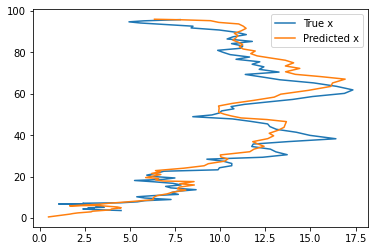

In [6]:
plt.plot(x[:,0], x[:,1])
plt.plot(hat_x[:,0], hat_x[:,1])
plt.legend(['True x', 'Predicted x'])
plt.show()